# Trabajo N°2: Análisis inferencial

Integrantes:
  * Cristián Astorga
  * Ailine Morales
  

Objetivos:

El objetivo del informe es realizar un análisis inferencial correspondiente a la base de datos del crucero "Titanic" con el fin de analizar la población de personas que abordaban el barco.
Dentro de los objetivos específicos del análisis se encuentra:

*   Estudiar las diferencias entre las clases. 

*   Estudiar las diferencias entre los precios y edades.
   
*   Estudiar las diferencias entre las personas que sobrevivieron y las que no sobrevivieron.



##Google Drive


In [ ]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/Lab

/content/gdrive/MyDrive/Lab


## Librerias

In [ ]:
!pip install xverse  ##instalar en caso de ser necesario

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Librerias base
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

#Test de normalidad
from scipy.stats import shapiro

#Kruskal Wallis
from scipy.stats import kruskal

#U de Mann Whitney 
from scipy.stats import mannwhitneyu
#Modelos de clasificación
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, roc_auc_score
from xverse.transformer import WOE
from xverse.graph import BarCharts 
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, naive_bayes, neighbors
import warnings
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

## Funciones



In [ ]:
# Se define una función para reemplazar los valores númericos por categorias según corresponda
# La función pide el dataframe, el nombre de la variable, los valores que toma, las categorias
# asociadas a cada valor, si se reemplazara la variable (por defecto se reemplaza) y en caso 
# de no reemplazarse se debe indicar el nombre nuevo para la variable.
def cod_var(df,nombre,values,labels,reemplazo = True,nombre_nuevo = None):
  if(reemplazo == True):
    df[nombre] = df[nombre].replace(values,labels)
  else:
    if(nombre_nuevo == None):
      print("error")
    else:
      df[nombre_nuevo] = df[nombre].replace(values,labels)

In [ ]:
# Se define una función que permite contar las observaciones según dos variables categóricas.
# Se debe entregar la base de datos y ambos nombres de las variables.
def conteo_dos_var(df,nombre1,nombre2):
  conteo_clases = df.groupby([nombre1,nombre2]).size()
  conteo_clases = conteo_clases.reset_index()
  conteo_clases.columns = [nombre1,nombre2,"Count"]
  return(conteo_clases)

In [ ]:
#Se define la función para gráfico de barra
#Pide como párametros la base de datos,la variable, posicion de de los indices
def bar_plot(df, nombre,rot = 'horizontal'): 
  conteo_generos = df[nombre].value_counts().reset_index()
  conteo_generos.columns = [nombre, 'Count']
  print(conteo_generos)
  print("-----------------")
  print(conteo_generos["Count"]/len(df[nombre]))
  print("-----------------")
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  plt.xticks(rotation=rot)
  plt.title("Gráfico de barras de "+nombre)
  ax.bar(conteo_generos[nombre],conteo_generos['Count'])
  plt.show()

In [ ]:
#Definición función para histograma
#Pide como parametros la base de datos, la variable, si se quiere o no la densidad
def hist(df,nombre,poligono = False):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  #ax.hist(x=df[nombre], color='#0E9092')
  if(poligono == True):
    y, edges, _ = ax.hist(x=df[nombre],color='#F2AB6D',density = True)
    midpoints = 0.5*(edges[1:]+edges[:-1])
    ax.plot(midpoints, y, 'r-*')
  else:
    y, edges, _ = ax.hist(x=df[nombre],color='#F2AB6D',density = True)
  plt.title('Histograma de '+nombre)
  plt.xlabel(nombre)
  plt.ylabel('Frecuencia')
  plt.show() 

In [ ]:
#Definición gráfico circular
#See tiene como parámetros la base de datos y la variable
def pie_plot(df,nombre):
  conteo_generos = df[nombre].value_counts().reset_index()
  conteo_generos.columns = [nombre, 'Count']
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1]) 
  plt.title("Gráfico circular de "+nombre)
  plt.pie(conteo_generos['Count'], labels = conteo_generos[nombre])
  plt.show()

In [ ]:
def shapiro_test(X,alpha = 0.05):
  stat, pvalue = shapiro(X)
  print("test de normalidad")
  print("-------------------------")
  print('stat=%.3f, p=%.3f' % (stat, pvalue))
  if pvalue > alpha:
	  print('Probably Gaussian')
  else:
    print('Probably not Gaussian')
  print("-----------------------")

In [ ]:
# curva de ROC
def plot_roc(y,prob,model_label):
    fpr,tpr,threshold= roc_curve(y,prob)  
    #fpr = false positive rate
    #tpr = true positive rate
    plt.figure(figsize=(10, 8), dpi=70)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("Curva de ROC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    pos = np.argmin(abs(threshold-0.5))
    plt.axvline(x=fpr[pos],color='r')
    plt.axhline(y=tpr[pos],color='r')
    auc = metrics.roc_auc_score(y, prob)
    pyplot.plot(fpr, tpr, color='blue', label=model_label)
    plt.text(0.95, 0.05, 'AUC = %0.2f' % auc, ha='right', fontsize=10, weight='bold', color='black')
    pyplot.legend()

In [ ]:
def Find_Optimal_Cutoff(y, prob):
    fpr, tpr, threshold = roc_curve(y, prob)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

In [ ]:
def performance_metrics(y,prob,threshold = 0.5):
    pred = ((prob >= threshold) * 1)   
    met = pd.DataFrame({"threshold":[threshold],
                        "accuracy":[np.round(metrics.accuracy_score(y, pred),2)],
                        "recall":[np.round(metrics.recall_score(y, pred),2)],
                        "precision":[np.round(metrics.precision_score(y, pred),2)],
                        "auc":[np.round(metrics.roc_auc_score(y, prob),2)]}) 
    return met

In [ ]:
def get_downsampling(df, Y, ratio1 =1):  #Balanceo de datos
    n1 = df[Y].sum()
    n0 = df.shape[0] - n1
    n0 = round((n1/(n0*ratio1))*n0)
    index0 = np.where(df[Y] == 0)[0]
    index1 = np.where(df[Y] == 1)[0]
    if(len(index0)>n0):
        index0 = random.sample(index0.tolist(),n0)
    else:
        index0 = random.choices(index0.tolist(),k=n0)
    index0.extend(index1)
    df = df.iloc[index0,:]
    n0 = ((df[Y] == 0)*1).sum()
    n1 = ((df[Y] == 1)*1).sum()
    print("N1/N0",round(n1/n0,2))
    return df

In [ ]:
def conf_matrix(y,prob, threshold = 0.5):
    pred = ((prob >= threshold) * 1)
    M = pd.DataFrame(metrics.confusion_matrix(y, pred, labels=[0,1]), 
                     index=['y:0', 'y:1'], columns=['pred:0', 'pred:1'])
    M = M.style.set_table_attributes("style='display:inline'").set_caption('Threshold:'+str(np.round(threshold,2)))
    return M

In [ ]:
"""
Evalua el performance de un modelo
:parameter
    :param y_test: array
    :param predicted: array
    :param predicted_prob: array
    :param show_thresholds: bool - si es verdadero muestra el threshold en los gráficos
"""
def evaluate_classif_model(y_test, predicted, predicted_prob, show_thresholds=True, figsize=(25,5)):
    classes = np.unique(y_test)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    ## Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy (overall correct predictions):",  round(accuracy,2))
    print("Auc:", round(auc,2))
    
    ## Precision e Recall
    recall = metrics.recall_score(y_test, predicted)  #= true 1s / all 1s in test (got and missed)
    precision = metrics.precision_score(y_test, predicted)  #= true 1s / all 1s predicted (true 1s + false 1s)
    f1 = metrics.f1_score(y_test, predicted)  #=2 * (precision * recall) / (precision + recall)
    print("Recall (all 1s predicted right):", round(recall,2))  #true positive rate, how many 1s I got
    print("Precision (confidence when predicting a 1):", round(precision,2))  #how many 1s were really 1s
    print("F1 score:", round(f1,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in classes]))
       
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, annot_kws={"size":15}, fmt='d', ax=ax[0], cmap=plt.cm.Blues, cbar=False)
    ax[0].set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax[0].set_yticklabels(labels=classes, rotation=0)
 
    ## Plot roc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob)    
    ax[1].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(fpr, tpr))
    ax[1].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[1].hlines(y=recall, xmin=-0.05, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[1].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
    ax[1].set(xlim=[-0.05,1], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax[1].legend(loc="lower right")
    ax[1].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[1].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), textcoords='offset points', ha='left', va='bottom')
                thres_in_plot.append(t)
    
    ## Plot precision-recall curve
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
    ax[2].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % metrics.auc(recalls, precisions))
    ax[2].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
    ax[2].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
    ax[2].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
    ax[2].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[2].legend(loc="lower left")
    ax[2].grid(True)
    if show_thresholds is True:
        thres_in_plot = []
        for i,t in enumerate(thresholds):
            t = np.round(t,1)
            if t not in thres_in_plot:
                ax[2].annotate(np.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='right', va='bottom')
                thres_in_plot.append(t)

    plt.show()

In [ ]:
def randomized_search(model, param_dic):
    dic_scores = {'accuracy':metrics.make_scorer(metrics.accuracy_score), 'precision':metrics.make_scorer(metrics.precision_score), 
                      'recall':metrics.make_scorer(metrics.recall_score), 'f1':metrics.make_scorer(metrics.f1_score)}
    grid_search = model_selection.RandomizedSearchCV(model, param_dic, scoring=dic_scores, refit='f1', random_state = 0).fit(X_train, y_train)
    print("Best Model parameters:", grid_search.best_params_)
    print("Best Model mean "+'f1'+":", round(grid_search.best_score_, 2))
    model = grid_search.best_estimator_
    return model

In [ ]:
def add_dummies(dtf, x, dropx=False):
    dtf_dummy = pd.get_dummies(dtf[x], prefix=x, drop_first=True, dummy_na=False)
    dtf = pd.concat([dtf, dtf_dummy], axis=1)
    print( dtf.filter(like=x, axis=1).head() )
    if dropx == True:
        dtf = dtf.drop(x, axis=1)
    return dtf

## Base de datos

In [ ]:
df = pd.read_csv("data_titanic.csv")

In [ ]:
df.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df = df.drop(columns=['Name','Ticket','Cabin']) #Se eliminan las variables ya que no tienen mayor influencia en el analisis

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [ ]:
df =  df.dropna()##se eliminan na

In [ ]:
df.isnull().sum()##se verifican nas presentes

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


# Análisis descriptivo e inferencial

## Pruebas de Normalidad
Se realiza la prubeda de normalidad de Shapiro - Wilk a todas las variables continuas.


In [ ]:
shapiro_test(df["Age"])

test de normalidad
-------------------------
stat=0.982, p=0.000
Probably not Gaussian
-----------------------


In [ ]:
shapiro_test(df["Fare"])

test de normalidad
-------------------------
stat=0.526, p=0.000
Probably not Gaussian
-----------------------


In [ ]:
data_SF = df['Age'].where(df['Survived']==1).dropna() 
data_SM = df['Age'].where(df['Survived']==0).dropna() 
lista_sexo = [data_SF,data_SM]
data_SF.head(2)
shapiro_test(data_SF)
shapiro_test(data_SM)

test de normalidad
-------------------------
stat=0.983, p=0.001
Probably not Gaussian
-----------------------
test de normalidad
-------------------------
stat=0.969, p=0.000
Probably not Gaussian
-----------------------


Se pudo apreciar que las variables continuas presentes en la base no cumplen el supuesto de normalidad

### Analisis Gráfico


In [ ]:
df.head(4)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S


In [ ]:
%matplotlib inline

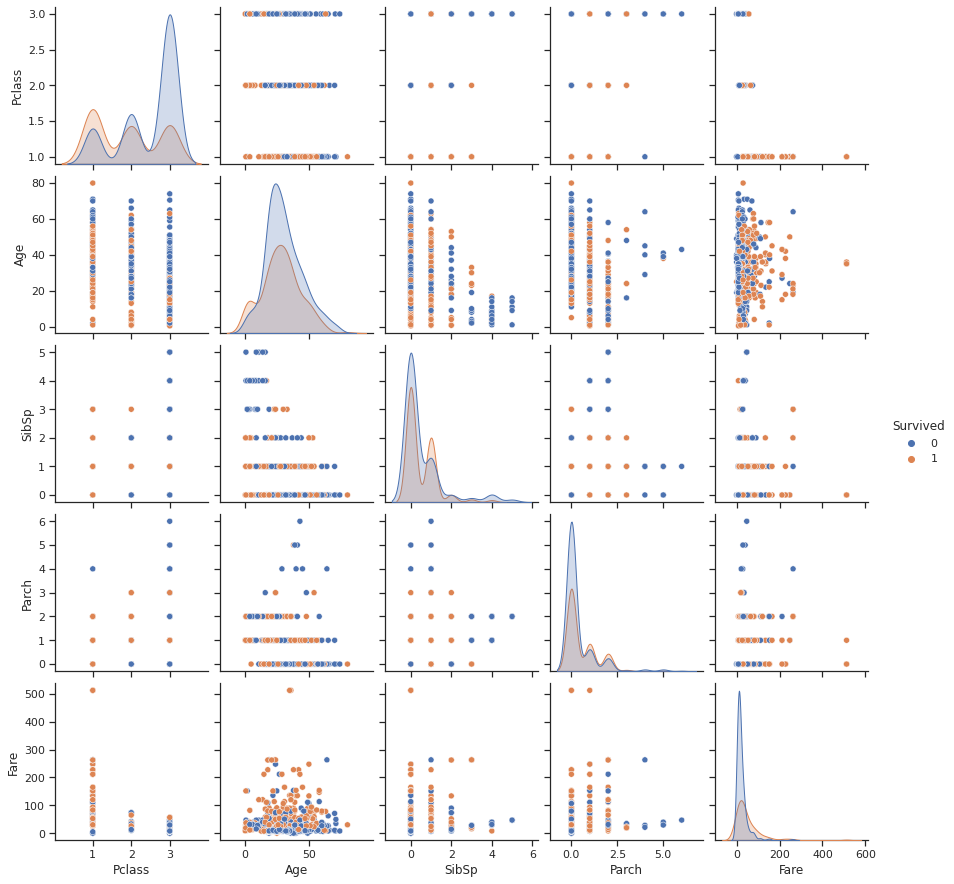

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df.drop(columns=["PassengerId","Sex","Embarked"]),
             hue="Survived")

### Edad según clase

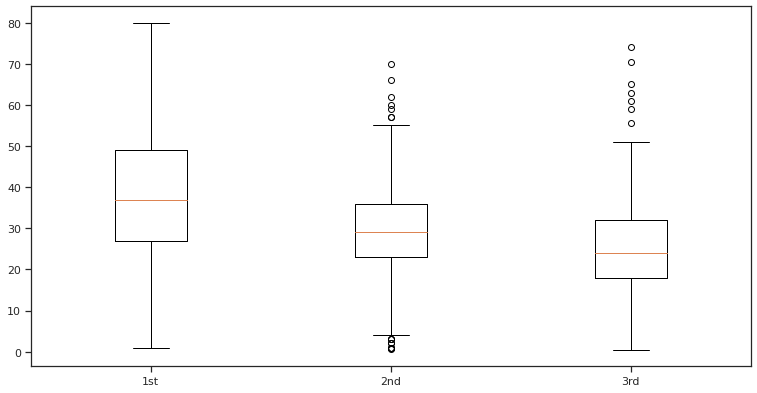

In [ ]:
data_Class1_age = df['Age'].where(df['Pclass']== 1).dropna() 
data_Class2_age = df['Age'].where(df['Pclass']== 2).dropna() 
data_Class3_age = df['Age'].where(df['Pclass']== 3).dropna()
lista_class_age = [data_Class1_age,data_Class2_age,data_Class3_age]

fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.boxplot(lista_class_age)
ax.set_xticklabels(['1st', '2nd','3rd'])
plt.show()

Se busca comparar si la diferencia de las edades entre las tres clases es distinta, y al no cumplirse el supuesto de normalidad se propone utilizar un test de Kruskal - Wallis, considerando las siguientes hipótesis:
$$ H_0: ME_{class1} = ME_{class2} = ME_{class3}~~~~~v/s~~~~~H_1: \exists~i,j~tal~que ME_i \neq ME_j~con i,j = class1,~class2,~class3$$ 

In [ ]:
stat, p = kruskal(data_Class1_age, data_Class2_age,data_Class3_age)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same median')
else:
	print('Probably different median')

stat=93.972, p=0.000
Probably different median


Considerando una significancia del 5% se rechaza $H_0$, es decir, existe evidencia significativa para pensar que almenos una de las medianas de las edades de las distintas clases difiere del resto.

### Precio según sobrevivencia del pasajero

In [ ]:
ns_fare = df['Fare'].where(df['Survived']==0).dropna()
s_fare = df['Fare'].where(df['Survived']==1).dropna()
list_fare_surv = [ns_fare,s_fare]
ns_age = df['Age'].where(df['Survived']==0).dropna()
s_age = df['Age'].where(df['Survived']==1).dropna()
list_age_surv = [ns_age,s_age]
ns_chil_par = df['Parch'].where(df['Survived']==0).dropna()
s_chil_par = df['Parch'].where(df['Survived']==1).dropna()
list_chil_surv = [ns_chil_par,s_chil_par]
ns_sib_spo = df['SibSp'].where(df['Survived']==0).dropna()
s_sib_spo = df['SibSp'].where(df['Survived']==1).dropna()
list_sib_surv = [ns_sib_spo,s_sib_spo]

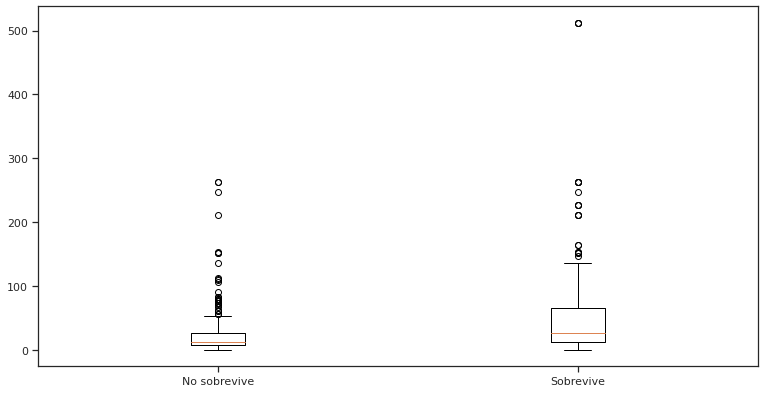

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.boxplot(list_fare_surv)
ax.set_xticklabels(['No sobrevive','Sobrevive'])
plt.show()

A priori respecto al gráfico de cajas se puede apreciar una pequeña diferencia en el precio que pagaron los pasajeros que sobrevivieron en comparación a los que no.

Para verificar si esta diferencia resulta significativa se propone el test U de Mann Whitney considerando el siguiente problema de hipótesis:
$$ H_0:ME_X = ME_Y ~~~~~v/s~~~~~H_1:ME_X < ME_Y $$
Con $X$: Precio pagado por los pasajeros que no sobrevivieron e 
$Y:$ Precio pagado popr los pasajeros que sobrevieron.

In [ ]:
stat, p = mannwhitneyu(ns_fare,s_fare, alternative = 'less')
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same median')
else:
	print('Probably less median')

stat=36952.500, p=0.000
Probably less median


Resulta evidente de los resultados rechazar $H_0$ con una significancia del 5%, es decir, existe evidencia para pensar que el precio pagado por los pasajeros que no sobrevivieron fue menor que el precio de los pasajeros que si sobrevivieron.

### Edad según sobrevivencia del pasajero

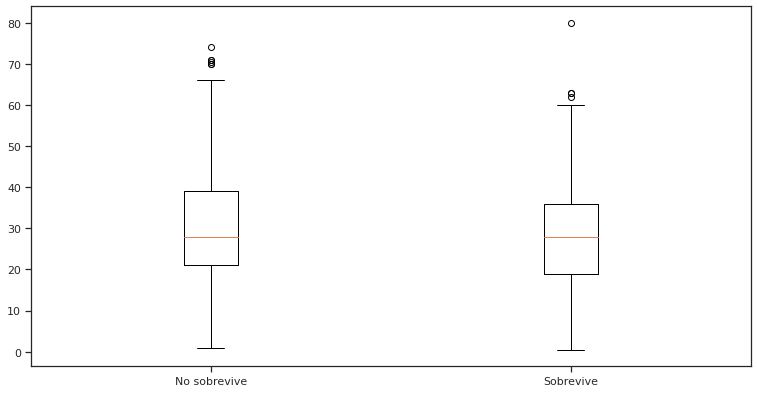

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.boxplot(list_age_surv)
ax.set_xticklabels(['No sobrevive','Sobrevive'])
plt.show()

A priori respecto al gráfico de cajas no se aprecian mayores diferencias en la edad de los pasajeros que sobrevivieron en comparación a los que no.

Para verificar si esta diferencia resulta significativa se propone el test U de Mann Whitney considerando el siguiente problema de hipótesis:
$$ H_0:ME_X = ME_Y ~~~~~v/s~~~~~H_1:ME_X \neq ME_Y $$
Con $X$: Edad de los pasajeros que no sobrevivieron e 
$Y:$ Edad de los pasajeros que sobrevieron.

In [ ]:
stat, p = mannwhitneyu(ns_age,s_age)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same median')
else:
	print('Probably different median')

stat=56961.000, p=0.064
Probably the same median


Respecto a los resultados, considerando una significancia del 5%, se recomienda no rechazar $H_0$, pero el p-value de 0.06 podría ser marginalmente significativo indicando no rechazar $H_0$.

### Cantidad de padres e hijos según clase

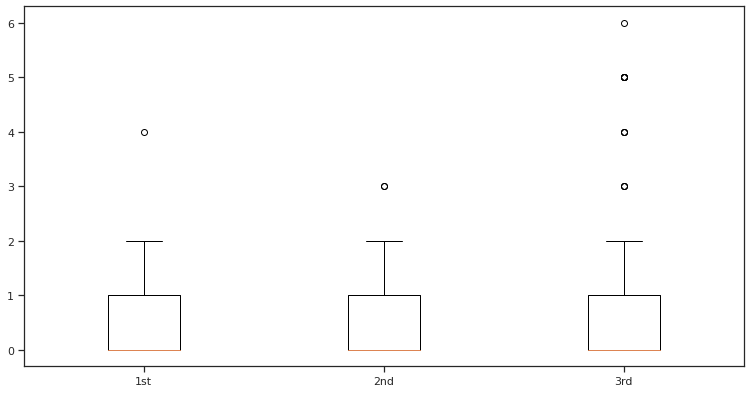

In [ ]:
data_Class1_chil = df['Parch'].where(df['Pclass']==1).dropna() 
data_Class2_chil = df['Parch'].where(df['Pclass']==2).dropna() 
data_Class3_chil = df['Parch'].where(df['Pclass']==3).dropna()
lista_class_chil = [data_Class1_chil,data_Class2_chil,data_Class3_chil]

fig = plt.figure(figsize = (10,5))
ax = fig.add_axes([0,0,1,1])
ax.boxplot(lista_class_chil)
ax.set_xticklabels(['1st', '2nd','3rd'])
plt.show()

Se busca comparar si la diferencia de la cantidad de hijos y padres entre las tres clases es distinta, y al no cumplirse el supuesto de normalidad se propone utilizar un test de Kruskal - Wallis, considerando las siguientes hipótesis:
$$ H_0: ME_{class1} = ME_{class2} = ME_{class3}~~~~~v/s~~~~~H_1: \exists~i,j~tal~que ME_i \neq ME_j~con i,j = class1,~class2,~class3$$ 

In [ ]:
stat, p = kruskal(data_Class1_chil, data_Class2_chil,data_Class3_chil)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same median')
else:
	print('Probably different median')

stat=0.373, p=0.830
Probably the same median


Según los resultados obtenidos de la prueba, estos indican no rechazar $H_0$, es decir, no existe evidencia significativa para dudar que las medianas del número de padres e hijos es igual entre las distintas clases.

## Correlaciones
Ya que no existen pruebas de que los datos sigan una distribución normal, se realiza un analisis de correlaciones de manera no parametrica.


Text(0.5, 1.0, 'Spearman correlation')

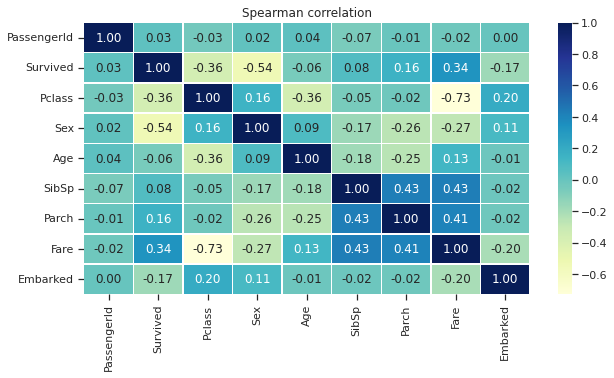

In [ ]:
df_corr = df.copy()
for col in df_corr.columns:
    if df_corr[col].dtype == "O":
        df_corr[col] = df_corr[col].factorize(sort=True)[0]
## matriz 
df_corr = df_corr.corr(method='spearman')
df_corr = df_corr
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap="YlGnBu", ax=ax, cbar=True, linewidths=0.5)
plt.title("Spearman correlation")

# Análisis de clasificación supervisado

## Preparación de datos

### Transformación de variables dummy

In [ ]:
df = add_dummies(df, x="Sex", dropx=True)
df = add_dummies(df, x="Pclass", dropx=True)
df = add_dummies(df, x="SibSp", dropx=True)
df = add_dummies(df, x="Embarked", dropx=True)

      Sex  Sex_male
0    male         1
1  female         0
2  female         0
3  female         0
4    male         1
   Pclass  Pclass_2  Pclass_3
0       3         0         1
1       1         0         0
2       3         0         1
3       1         0         0
4       3         0         1
   SibSp  SibSp_1  SibSp_2  SibSp_3  SibSp_4  SibSp_5
0      1        1        0        0        0        0
1      1        1        0        0        0        0
2      0        0        0        0        0        0
3      1        1        0        0        0        0
4      0        0        0        0        0        0
  Embarked  Embarked_Q  Embarked_S
0        S           0           1
1        C           0           0
2        S           0           1
3        S           0           1
4        S           0           1


In [ ]:
df.head()

,PassengerId,Survived,Age,Parch,Fare,Sex_male,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Embarked_Q,Embarked_S
0,1,0,22.0,0,7.2500,1,0,1,1,0,0,0,0,0,1
1,2,1,38.0,0,71.2833,0,0,0,1,0,0,0,0,0,0
2,3,1,26.0,0,7.9250,0,0,1,0,0,0,0,0,0,1
3,4,1,35.0,0,53.1000,0,0,0,1,0,0,0,0,0,1
4,5,0,35.0,0,8.0500,1,0,1,0,0,0,0,0,0,1


### Separación de base de datos en Train/Test

In [ ]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.3, shuffle=False) 
print("X_train shape:", df_train.drop("Survived", axis=1).shape, "| X_test shape:", df_test.drop("Survived", axis=1).shape)
print("y_train mean:", round(np.mean(df_train["Survived"]),2), "| y_test mean:", round(np.mean(df_test["Survived"]),2))
print(df_train.shape[1], "features:", df_train.drop("Survived", axis=1).columns.to_list())

X_train shape: (498, 14) | X_test shape: (214, 14)
y_train mean: 0.41 | y_test mean: 0.38
15 features: ['PassengerId', 'Age', 'Parch', 'Fare', 'Sex_male', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'Embarked_Q', 'Embarked_S']


### Escalamiento de variables

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaler.fit(df_train.drop("Survived", axis=1))
X = scaler.transform(df_train.drop("Survived", axis=1))
dtf_scaled = pd.DataFrame(X, columns=df_train.drop("Survived", axis=1).columns, index=df_train.index)
dtf_scaled["Survived"] = df_train["Survived"]
dtf_train = dtf_scaled

In [ ]:
dtf_train.head()

,PassengerId,Age,Parch,Fare,Sex_male,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Embarked_Q,Embarked_S,Survived
0,0.000000,0.268139,0.0,0.014151,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.001587,0.470032,0.0,0.139136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.003175,0.318612,0.0,0.015469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,0.004762,0.432177,0.0,0.103644,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.006349,0.432177,0.0,0.015713,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


## Modelos de clasificación

### Gradient Boosting Classifier

In [ ]:
X_train = dtf_train.drop(columns="Survived").values
y_train = dtf_train["Survived"].values
X_test = df_test.drop(columns="Survived").values
y_test = df_test["Survived"].values

In [ ]:
model = ensemble.GradientBoostingClassifier()
param_dic = {'learning_rate':[0.01,0.03,0.1],      #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,300,1000],  #number of trees added to the model
             'max_depth':[3,10],                             #maximum depth of the tree
             'min_samples_split':[3,10,30,100],         #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,10],                        #the minimum number of samples to form a leaf
             'max_features':[3,9],                          #square root of features is usually a good starting point
             'subsample':[0.75,0.85,0.95,1]}            #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

In [ ]:
model1 = randomized_search(model, param_dic)

Best Model parameters: {'subsample': 0.75, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.03}
Best Model mean f1: 0.68


In [ ]:
model1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.03, max_features=3,
                           min_samples_leaf=10, min_samples_split=10,
                           subsample=0.75)

In [ ]:
# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_score = cross_val_score(
                    estimator = model1,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )
print("Metricas cross_validation", cv_score)
 
print("Media de cross_validation", cv_score.mean())

Metricas cross_validation [0.76       0.77       0.79       0.75757576 0.78787879]
Media de cross_validation 0.7730909090909093


In [ ]:
predicted1 = model1.predict(X_test)
predicted_prob1 = model1.predict_proba(X_test)[:, 1]

###K Nearest Neighbors

In [ ]:
model = neighbors.KNeighborsClassifier() 
param_dic = {'n_neighbors':[2,3,5,10], #Number of neighbors to use
             'weights':['uniform', 'distance'], #Weight function used in prediction
             'algorithm':['auto','ball_tree','kd_tree','brute'], #Algorithm used to compute the nearest neighbors
             'leaf_size':[3,10,30,100], #Leaf size passed to BallTree or KDTree
             'p':[1,2]}, #Power parameter for the Minkowski metric

In [ ]:
model2 = randomized_search(model, param_dic)
model2.fit(X_train, y_train)

Best Model parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 5, 'leaf_size': 3, 'algorithm': 'brute'}
Best Model mean f1: 0.68


KNeighborsClassifier(algorithm='brute', leaf_size=3, p=1)

In [ ]:
# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_score = cross_val_score(
                    estimator = model2,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )
print("Metricas cross_validation", cv_score)
 
print("Media de cross_validation", cv_score.mean())

Metricas cross_validation [0.83       0.8        0.77       0.76767677 0.78787879]
Media de cross_validation 0.7911111111111111


In [ ]:
predicted2 = model2.predict(X_test)
predicted_prob2 = model2.predict_proba(X_test)[:, 1]

###Gaussian Naive Bayes

In [ ]:
model = naive_bayes.GaussianNB()
param_dic = {'var_smoothing':[0.000000001,0.000000003,0.00000001,0.00000003, 0.0000001]} #Portion of the largest variance of all features that is added to variances for calculation stability.

In [ ]:
model3 = randomized_search(model, param_dic)
model3.fit(X_train, y_train)


Best Model parameters: {'var_smoothing': 1e-07}
Best Model mean f1: 0.59


GaussianNB(var_smoothing=1e-07)

In [ ]:
# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_score = cross_val_score(
                    estimator = model3,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )
print("Metricas cross_validation", cv_score)
 
print("Media de cross_validation", cv_score.mean())

Metricas cross_validation [0.48       0.37       0.48       0.38383838 0.47474747]
Media de cross_validation 0.4377171717171717


In [ ]:
predicted3 = model3.predict(X_test)
predicted_prob3 = model3.predict_proba(X_test)[:, 1]

###Evaluación Clasificadores

Accuracy (overall correct predictions): 0.77
Auc: 0.86
Recall (all 1s predicted right): 0.67
Precision (confidence when predicting a 1): 0.71
F1 score: 0.69
Detail:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       132
           1       0.71      0.67      0.69        82

    accuracy                           0.77       214
   macro avg       0.75      0.75      0.75       214
weighted avg       0.76      0.77      0.77       214



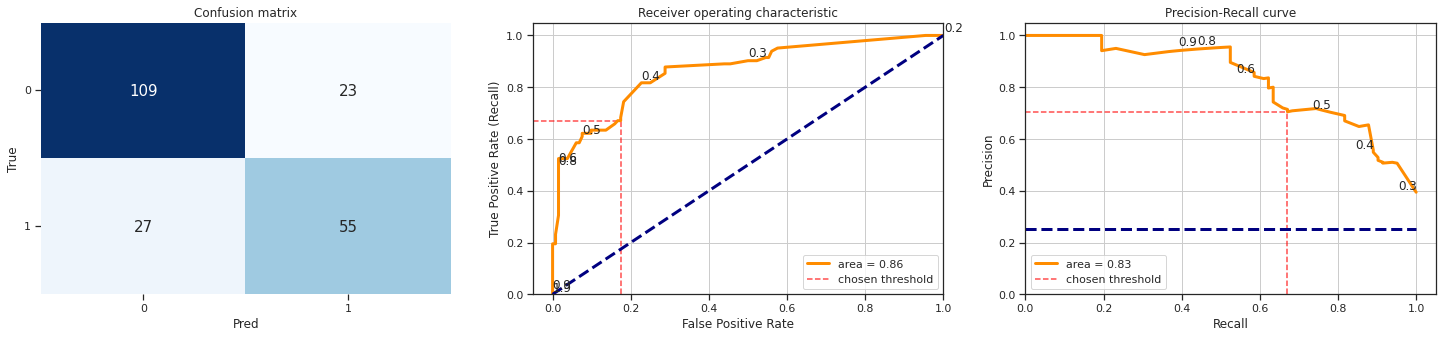

In [ ]:
evaluate_classif_model(y_test, predicted1, predicted_prob1, figsize=(25,5))

Accuracy (overall correct predictions): 0.77
Auc: 0.82
Recall (all 1s predicted right): 0.52
Precision (confidence when predicting a 1): 0.81
F1 score: 0.64
Detail:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       132
           1       0.81      0.52      0.64        82

    accuracy                           0.77       214
   macro avg       0.78      0.72      0.73       214
weighted avg       0.78      0.77      0.76       214



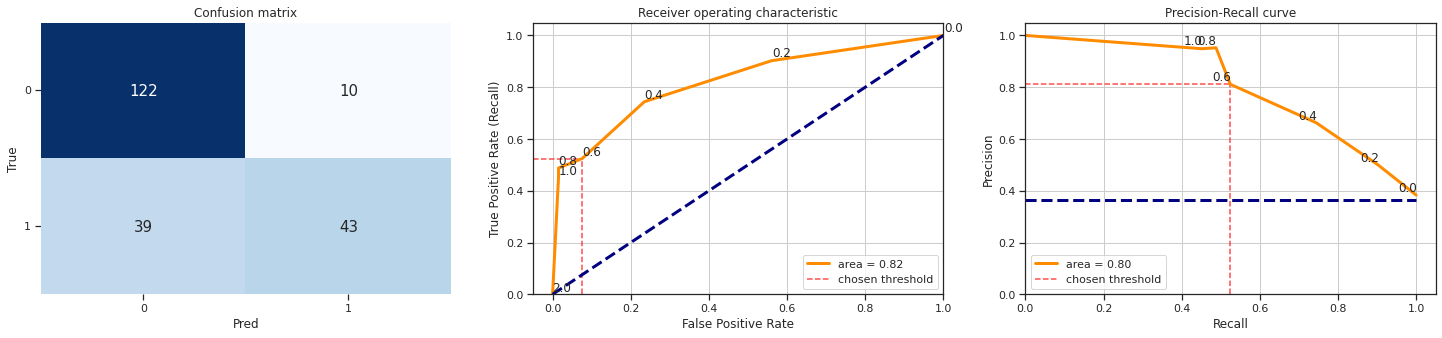

In [ ]:
evaluate_classif_model(y_test, predicted2, predicted_prob2, figsize=(25,5))

Accuracy (overall correct predictions): 0.69
Auc: 0.64
Recall (all 1s predicted right): 0.44
Precision (confidence when predicting a 1): 0.64
F1 score: 0.52
Detail:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       132
           1       0.64      0.44      0.52        82

    accuracy                           0.69       214
   macro avg       0.68      0.64      0.65       214
weighted avg       0.68      0.69      0.68       214



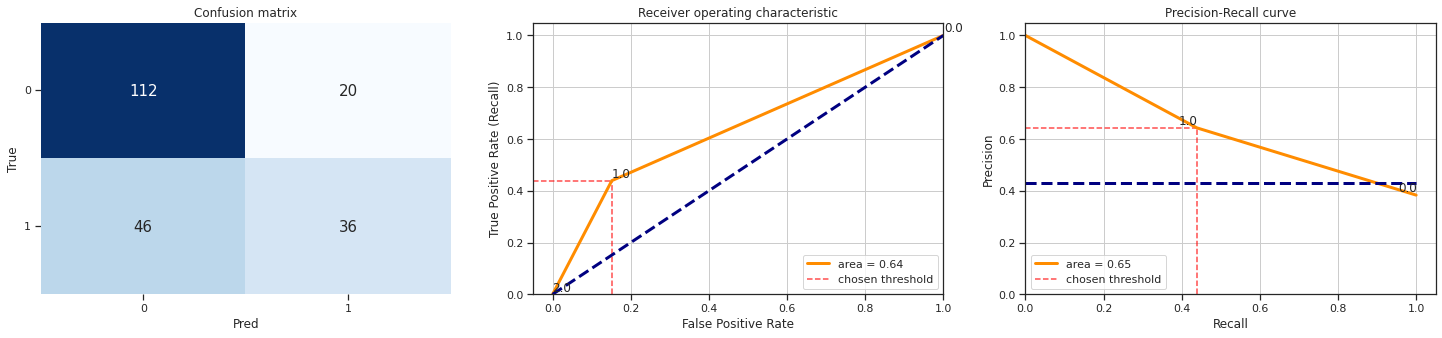

In [ ]:
evaluate_classif_model(y_test, predicted3, predicted_prob3, figsize=(25,5))

#Regresión Logística

In [ ]:
logistic_lasso_model = LogisticRegression(solver = 'liblinear', max_iter = 200, penalty = 'l1', C = 0.1, random_state = 123)
logistic_lasso_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=200, penalty='l1', random_state=123,
                   solver='liblinear')

In [ ]:
df_lasso_coef = pd.DataFrame(dict({'var_name':df_train.drop(columns = ["Survived"]).columns.to_list(),
                             'coef': logistic_lasso_model.coef_.tolist()[0]}))
df_lasso_coef

,var_name,coef
0,PassengerId,0.128629
1,Age,0.000000
2,Parch,0.000000
3,Fare,0.000000
4,Sex_male,-1.724925
5,Pclass_2,0.000000
6,Pclass_3,-0.660972
7,SibSp_1,0.000000
8,SibSp_2,0.000000
9,SibSp_3,0.000000


In [ ]:
sig_lasso_vars = df_lasso_coef.query('`coef`!=0')['var_name'].to_list()
sig_lasso_vars

['PassengerId', 'Sex_male', 'Pclass_3']

In [ ]:
X_train = df_train.drop(columns = ["Survived"])[sig_lasso_vars].values
X_test = df_test.drop(columns = ["Survived"])[sig_lasso_vars].values

In [ ]:
model_lasso = LogisticRegression(solver = 'lbfgs', max_iter = 200, penalty = 'none', random_state = 123)
model_lasso.fit(X_train, y_train)

LogisticRegression(max_iter=200, penalty='none', random_state=123)

In [ ]:
predicted = model_lasso.predict(X_test)
predicted_prob = model_lasso.predict_proba(X_test)[:,1]

Accuracy (overall correct predictions): 0.77
Auc: 0.82
Recall (all 1s predicted right): 0.66
Precision (confidence when predicting a 1): 0.72
F1 score: 0.69
Detail:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       132
           1       0.72      0.66      0.69        82

    accuracy                           0.77       214
   macro avg       0.76      0.75      0.75       214
weighted avg       0.77      0.77      0.77       214



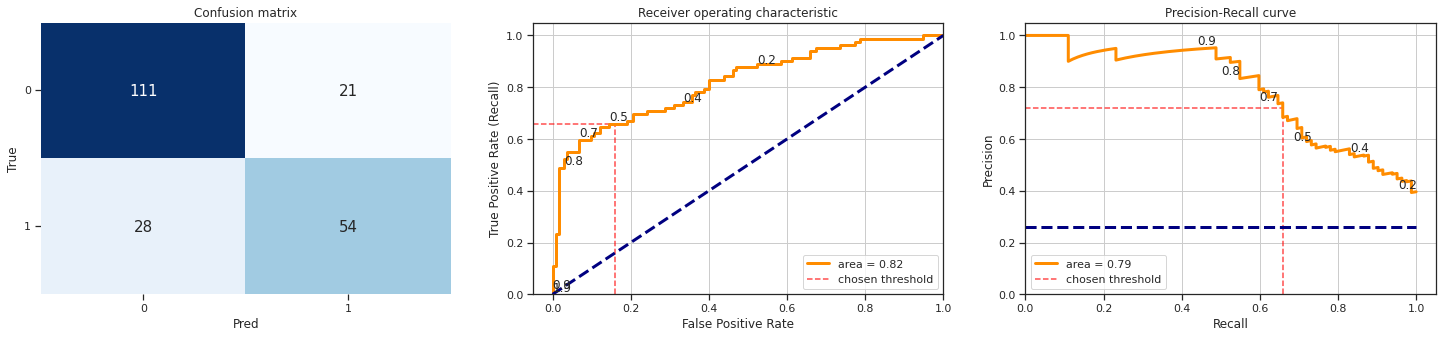

In [ ]:
evaluate_classif_model(y_test, predicted, predicted_prob, figsize=(25,5))

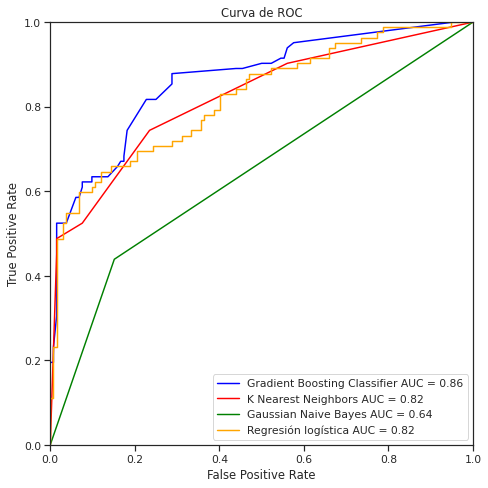

In [ ]:
fpr1, tpr1, threshold1 = roc_curve(y_test,predicted_prob1)
fpr2, tpr2, threshold2 = roc_curve(y_test,predicted_prob2)
fpr3, tpr3, threshold3 = roc_curve(y_test,predicted_prob3)
fpr4, tpr4, threshold4 = roc_curve(y_test,predicted_prob)
plt.figure(figsize=(10, 8), dpi=70)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Curva de ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
auc1 = metrics.roc_auc_score(y_test,predicted_prob1)
auc2= metrics.roc_auc_score(y_test,predicted_prob2)
auc3 = metrics.roc_auc_score(y_test,predicted_prob3)
auc4 = metrics.roc_auc_score(y_test,predicted_prob)
pyplot.plot(fpr1, tpr1, color='blue', label="Gradient Boosting Classifier AUC = %0.2f" % auc1)
pyplot.plot(fpr2, tpr2, color='red', label="K Nearest Neighbors AUC = %0.2f" % auc2)
pyplot.plot(fpr3, tpr3, color='green', label="Gaussian Naive Bayes AUC = %0.2f" % auc3)
pyplot.plot(fpr4, tpr4, color='orange', label="Regresión logística AUC = %0.2f" % auc4)
pyplot.legend()